In [4]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
tf.random.set_seed(1)


In [6]:
articles = pd.read_csv("Article-2022-05-08.csv")

In [7]:
articles.shape

(2681, 19)

In [8]:
articles_labeled = articles.copy()
articles_labeled['key_terms'] = articles['key_terms'].apply(lambda s: [l for l in str(s).split(',')])
mlb = MultiLabelBinarizer()
mlb.fit(articles_labeled["key_terms"])
articles_labeled['text'] = articles_labeled['text'].fillna("")
articles_labeled['text'] = articles_labeled['title'] + articles_labeled['text']

In [9]:
articles_labeled.head()

,id,created_at,updated_at,key_terms,companies,source_id,source_name,source_domain,source_url,title,description,author,published_at,url,image_url,text,summary,text_sentiment,title_sentiment
0,1194,2021-06-18 12:12:45,2021-06-18 12:12:46,[5],188,NaN,thecsrjournal,thecsrjournal.in,https://thecsrjournal.in,FedEx Commits to Carbon-Neutral Operations by ...,FedEx Commits to Carbon-Neutral Operations by ...,The Csr Journal,2021-03-13 08:23:09,https://thecsrjournal.in/fedex-carbon-neutral-...,https://gnewsapi.net/redirect-news-image/289b1...,FedEx Commits to Carbon-Neutral Operations by ...,NaN,NaN,-0.981564
1,1709,2021-06-18 12:12:45,2021-06-18 12:12:46,[15],206,NaN,KIRO Seattle,www.kiro7.com,https://www.kiro7.com,Black scholar: It's time France confronts its ...,Black scholar: It's time France confronts its ...,Sylvie Corbet Jared Leone Cox Media Group Nati...,2021-03-13 07:57:57,https://www.kiro7.com/entertainment/black-scho...,https://gnewsapi.net/redirect-news-image/37062...,Black scholar: It's time France confronts its ...,NaN,NaN,0.816899
2,1949,2021-06-18 12:12:45,2021-06-18 12:12:46,[5],31,NaN,Gulf News,gulfnews.com,https://gulfnews.com,Network International is optimistic on region'...,Network International is optimistic on region'...,NaN,2021-03-13 06:54:33,https://gulfnews.com/business/banking/network-...,https://gnewsapi.net/redirect-news-image/888d3...,Network International is optimistic on region'...,NaN,NaN,0.969982
3,1547,2021-06-18 12:12:45,2021-06-18 12:12:46,[4],206,NaN,Yahoo News Canada,ca.news.yahoo.com,https://ca.news.yahoo.com,No winning ticket for Friday night's $44.8 mil...,No winning ticket for Friday night's $44.8 mil...,NaN,2021-03-13 06:11:38,https://ca.news.yahoo.com/no-winning-ticket-fr...,https://gnewsapi.net/redirect-news-image/e439c...,No winning ticket for Friday night's $44.8 mil...,NaN,NaN,-0.998206
4,2316,2021-06-18 12:12:45,2021-06-18 12:12:46,[8],421,NaN,The Robesonian,www.robesonian.com,https://www.robesonian.com,UNCP's virtual Women's Empowerment Summit is F...,UNCP's virtual Women's Empowerment Summit is F...,NaN,2021-03-13 04:49:00,https://www.robesonian.com/uncategorized/14356...,https://gnewsapi.net/redirect-news-image/9feaa...,UNCP's virtual Women's Empowerment Summit is F...,NaN,NaN,0.904579


In [10]:
y_bin = mlb.transform(articles_labeled["key_terms"])
y_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
import nltk
from nltk.corpus import stopwords
from string import punctuation
import re
nltk.download('stopwords')
stops = set(stopwords.words('english'))
stops.add("'s")
stops.remove("not")


def clean(sentence):
    # delete stopwords
    temp = " ".join(filter(lambda x: x not in stops, sentence.split()))
    # Remove punctuation
    temp = temp.translate(str.maketrans('', '', punctuation))
    # remove non-english characters
    temp = temp.encode("ascii", "ignore").decode()
    # Change all to lower case
    temp = temp.lower()
    # Delete numbers
    temp = re.sub(r'[0-9]', "", temp)
    # Delete excessive spaces and return
    return re.sub("  ", " ", temp)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wmy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
articles_labeled["text"] = articles_labeled["text"].apply(clean)

In [13]:
data = tf.data.Dataset.from_tensor_slices((articles_labeled["text"], y_bin))
data = data.shuffle(buffer_size = len(data), seed=1)
train_size = int(0.7*len(data))
val_size   = int(0.1*len(data)) 

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

In [14]:
# only the top distinct words will be tracked
max_tokens = 2000

# each headline will be a vector of length 25
sequence_length = 25

vectorize_layer = TextVectorization(
    max_tokens=max_tokens, # only consider this many words
    output_mode='int',
    output_sequence_length=sequence_length) 

In [15]:
headlines = train.map(lambda x, y: x)
vectorize_layer.adapt(headlines)

In [16]:
def vectorize_headline(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_headline)
val_vec = val.map(vectorize_headline)
test_vec = test.map(vectorize_headline)

In [99]:
model2 = tf.keras.Sequential([
    layers.Embedding(max_tokens, output_dim = 64, name="embedding"),
    layers.Dropout(0.2),
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(tf.keras.layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(16, activation="sigmoid")]
)



In [100]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [101]:
with tf.device('/GPU:0'):
    history2 = model2.fit(train_vec, epochs = 30, validation_data = val_vec)

Epoch 1/30
1876/1876 [==============================] - 49s 22ms/step - loss: 0.2538 - accuracy: 0.0869 - auc_3: 0.6281 - val_loss: 0.2461 - val_accuracy: 0.1231 - val_auc_3: 0.6729
Epoch 2/30
1876/1876 [==============================] - 42s 22ms/step - loss: 0.2360 - accuracy: 0.0954 - auc_3: 0.6597 - val_loss: 0.2326 - val_accuracy: 0.0746 - val_auc_3: 0.6730
Epoch 3/30
1876/1876 [==============================] - 44s 24ms/step - loss: 0.2269 - accuracy: 0.1583 - auc_3: 0.7168 - val_loss: 0.2093 - val_accuracy: 0.2015 - val_auc_3: 0.7911
Epoch 4/30
1876/1876 [==============================] - 50s 27ms/step - loss: 0.2119 - accuracy: 0.2308 - auc_3: 0.7799 - val_loss: 0.1936 - val_accuracy: 0.3507 - val_auc_3: 0.8511
Epoch 5/30
1876/1876 [==============================] - 44s 23ms/step - loss: 0.1984 - accuracy: 0.3129 - auc_3: 0.8202 - val_loss: 0.1726 - val_accuracy: 0.4104 - val_auc_3: 0.8966
Epoch 6/30
1876/1876 [==============================] - 51s 27ms/step - loss: 0.1851 - acc

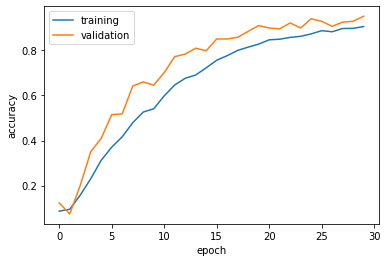

In [103]:
from matplotlib import pyplot as plt
plt.plot(history2.history["accuracy"], label = "training")
plt.plot(history2.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In [104]:
model2.evaluate(test_vec)

537/537 [==============================] - 6s 10ms/step - loss: 0.0208 - accuracy: 0.9330 - auc_3: 0.9972


[0.02082742750644684, 0.9329608678817749, 0.9971862435340881]

In [105]:
a = model2.predict(test_vec)

537/537 [==============================] - 5s 8ms/step


In [106]:
np.round(a[1])

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [107]:
mlb.classes_

array(['1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5',
       '6', '7', '8', '9'], dtype=object)

In [110]:
# !mkdir -p saved_model
model2.save('saved_model/classfication_model_multi_label.h5')


In [19]:
new_model = tf.keras.models.load_model('saved_model/classfication_model_multi_label.h5')

In [20]:
keys = dict(zip(range(16), [int(i) for i in ['1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5',
       '6', '7', '8', '9']]))

def idx_to_label(arr):
    return [[keys[i] for i in range(16) if j[i] == 1] for j in arr]

def predict(x):
    """
    predict labels
    @params x: 1d or 2d array or list
    @return labels in a 2d array
    """
    x = np.array(x).reshape(-1,)
    x = np.array(list(map(clean, x)))
    x = tf.expand_dims(x, -1)
    return idx_to_label(np.round(new_model.predict(vectorize_layer(x))))  


In [21]:
predict(np.array(["he", 'black lives matter']))

1/1 [==============================] - 7s 7s/step


[[], [15]]

In [22]:
predict(np.array([["he"], ['black lives matter']]))

1/1 [==============================] - 0s 75ms/step


[[], [15]]